In [202]:
# The UCB BOTORCH model

import torch
from pyDOE3 import lhs

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize

from gpytorch import kernels, means, likelihoods
from gpytorch.priors import LogNormalPrior
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt

In [203]:
# Config
# ================================================================== #

seed = 421
noise_level = 0.2
initial_sample = 24
nu=2.5

bounds = torch.tensor([[6.0, 20.0], [8.0, 40.0]], dtype=torch.double)

dim = bounds.shape[1]

lhs_design = torch.tensor(lhs(n=dim, samples=initial_sample, criterion = 'maximin', random_state=seed), dtype=torch.double)

scaled_lhs_design = bounds[0] + (bounds[1] - bounds[0])*lhs_design

In [204]:
def objective_function(X, 
                       pHopt = 7,
                       temp_opt = 35,
                       a = 100,
                       b = 20,
                       c = 1,
                       noise_level = noise_level,
                       seed = None):
    if seed is not None:
        torch.manual_seed(seed)
    pH, temp = X[:, 0], X[:, 1]
    y = a - b * (pH-pHopt)**2 - c * (temp-temp_opt)**2
    noise = noise_level * a * torch.randn_like(y)
    
    return y + noise

train_X = scaled_lhs_design
train_Y = objective_function(train_X)
train_Y = train_Y.unsqueeze(-1)

In [205]:
def objective_function(X, pHopt =7, pHopt2 = 5.5, temp_opt =35, temp_opt2=30,  a = 100, b = 20, c = 1, noise_level = noise_level, seed = None):
    if seed is not None:
            torch.manual_seed(seed) # set for reproducibility
    pH, temp = X[:, 0], X[:, 1]

    # First peak at (pH=7, temp=35)
    pH_term1 = torch.exp(-0.5 * ((pH - pHopt) / 1.5)**2)  # Gaussian term for pH with width 1.5
    temp_term1 = torch.exp(-0.5 * ((temp - temp_opt) / 5.0)**2)  # Gaussian term for temp with width 5.0

    # Second peak at (pH=5.5, temp=30)
    pH_term2 = torch.exp(-0.5 * ((pH - pHopt2) / 1.5)**2)
    temp_term2 = torch.exp(-0.5 * ((temp - temp_opt2) / 5.0)**2)

    # Stronger Sinusoidal Modulation
    sin_component = torch.sin(2 * pH) * torch.cos(1.5 * temp)  # Higher frequency
    wave_strength = 1.5  # Scale up the wave effect

    # Combine the two peaks with the stronger sinusoidal variation
    y = (pH_term1 * temp_term1 + pH_term2 * temp_term2) * (1 + wave_strength * sin_component) *100

    noise = noise_level *y* torch.randn_like(y) # changed this here from Isabella's to make noise homoscedastic (same for all points)
    return y + noise

train_X = scaled_lhs_design
train_Y = objective_function(train_X, seed=seed)
train_Y = train_Y.unsqueeze(-1)


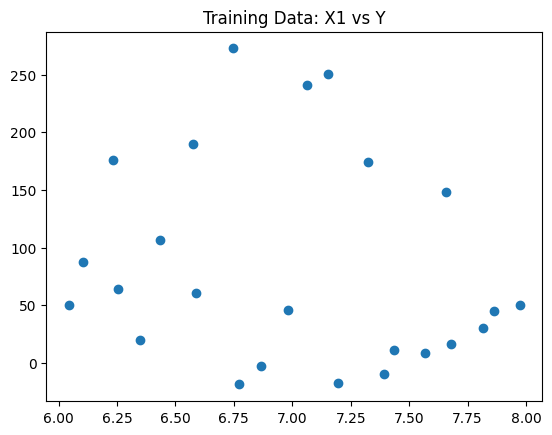

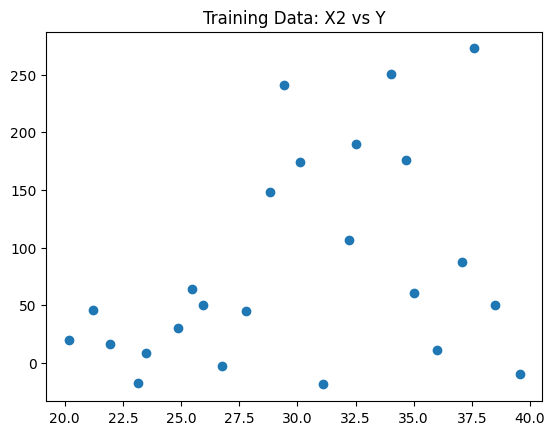

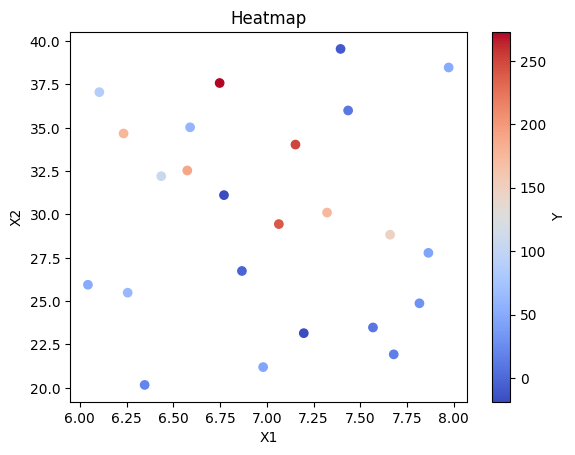

In [206]:
# plot the initial design
plt.scatter(train_X[:, 0], train_Y)
plt.title('Training Data: X1 vs Y')
plt.show()

plt.scatter(train_X[:, 1], train_Y)
plt.title('Training Data: X2 vs Y')
plt.show()

plt.scatter(train_X[:, 0], train_X[:, 1], c = train_Y, cmap='coolwarm')
plt.title('Heatmap')
plt.xlabel('X1')
plt.ylabel('X2')
plt.colorbar(label='Y')
plt.show()

In [207]:
class UCBModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, nu=2.5,
                 lengthscale_prior=None, outputscale_prior=None,
                 lengthscale_constraint=None, outputscale_constraint=None):
        likelihood = likelihoods.GaussianLikelihood()
        mean_module = means.ZeroMean() # Options here to change mean
        covar_module = kernels.ScaleKernel(kernels.MaternKernel(nu=nu, ard_num_dims = dim))
        
        super().__init__(train_X, train_Y, likelihood=likelihood, mean_module= mean_module, covar_module = covar_module, outcome_transform = Standardize(m=1), input_transform = Normalize(d=dim))        
       
      

def train_UCB_model(train_X, train_Y):
    model = UCBModel(train_X, train_Y, nu=nu) #  this uses the nu parameter in config
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model, mll

def predict_UCB(model, X):
    model.eval()
    with torch.no_grad():
        posterior = model(X)
        mean = posterior.mean
        std = posterior.stddev
        return mean, std
    

In [208]:
# plot acquisition and GP surface
from matplotlib import cm

def plot_acquisition(acq_func, bounds, title="Acquisition Function"):
    """
    Plots a 2D acquisition function in raw input space.
    
    Parameters:
    - acq_func: acquisition function (expects unnormalized input)
    - bounds: tensor of shape [2, d] with raw input bounds
    - title: optional title for the plot
    """
    # Create a grid in raw space
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], 100)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], 100)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    X_normal = normalize(X_raw, bounds=bounds)
    with torch.no_grad():
        # Evaluate acquisition function (expects [n, 1, d])
        acq_values = acq_func(X_normal.unsqueeze(1)).squeeze(-1).cpu()

    # Reshape for heatmap
    Z = acq_values.reshape(100, 100)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.contourf(X1.numpy(), X2.numpy(), Z.numpy(), levels=50, cmap="viridis")
    plt.colorbar(label="Acquisition Value")
    plt.xlabel("X1 (raw)")
    plt.ylabel("X2 (raw)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_gp_surface(model, bounds, grid_size=50, plot_type="mean", title=None):
    """
    Plots the posterior mean or standard deviation (uncertainty) of a 2D GP model.
    
    Parameters:
    - model: trained GP model (expects raw input if input_transform is set)
    - bounds: tensor of shape [2, d] with raw input bounds
    - grid_size: number of grid points per dimension
    - plot_type: "mean" or "std"
    - title: optional title for the plot
    """
    x1 = torch.linspace(bounds[0, 0], bounds[1, 0], grid_size)
    x2 = torch.linspace(bounds[0, 1], bounds[1, 1], grid_size)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    X_raw = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)

    with torch.no_grad():
        posterior = model.posterior(X_raw)
        if plot_type == "mean":
            Z = posterior.mean.reshape(grid_size, grid_size).cpu()
        elif plot_type == "std":
            Z = posterior.variance.sqrt().reshape(grid_size, grid_size).cpu()
        else:
            raise ValueError("plot_type must be 'mean' or 'std'")

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1.numpy(), X2.numpy(), Z.numpy(), cmap=cm.viridis)
    ax.set_xlabel("X1 (raw)")
    ax.set_ylabel("X2 (raw)")
    ax.set_zlabel(plot_type)
    ax.set_title(title or f"GP Posterior {plot_type.capitalize()} Surface")
    plt.tight_layout()
    plt.show()


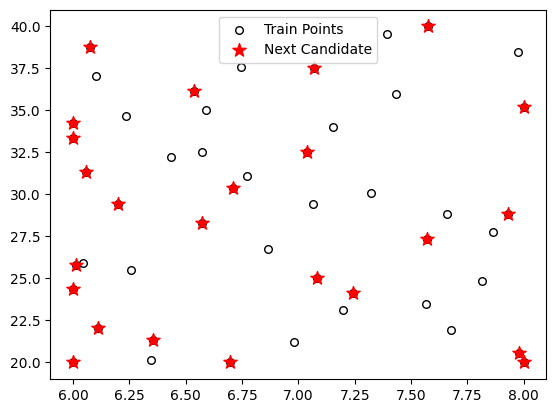

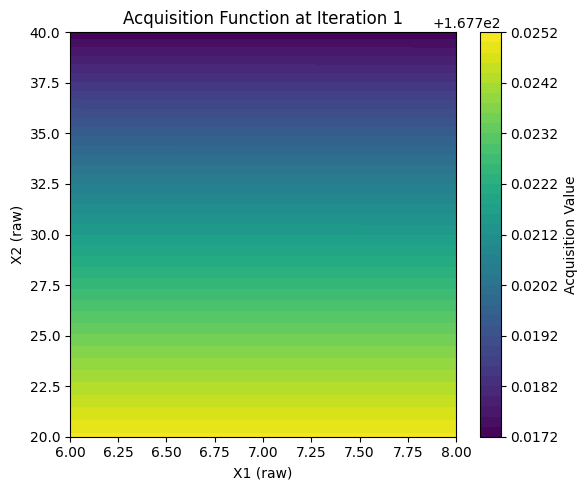

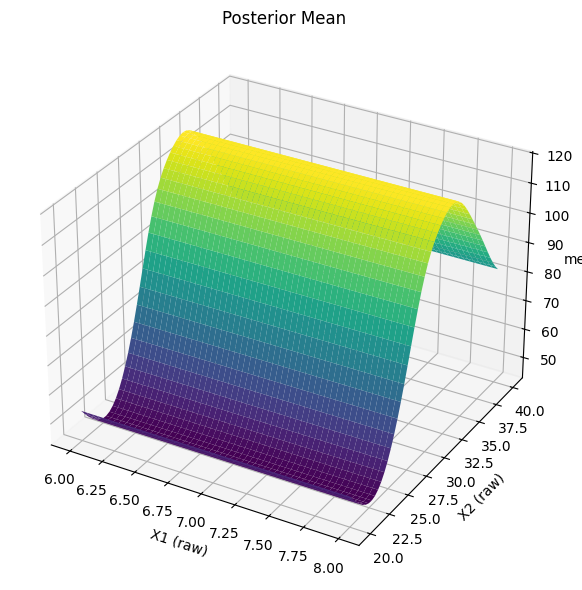

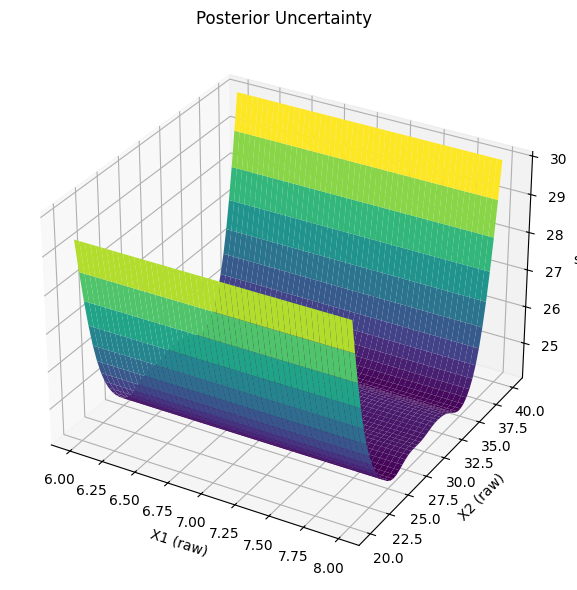

Best Y: 283.6412 at X: tensor([ 7.0713, 37.5311], dtype=torch.float64)
noise 0.7890615080294777
Lengthscales: tensor([[54.4404,  0.2097]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Outputscale: tensor(0.1759, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\optim\optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


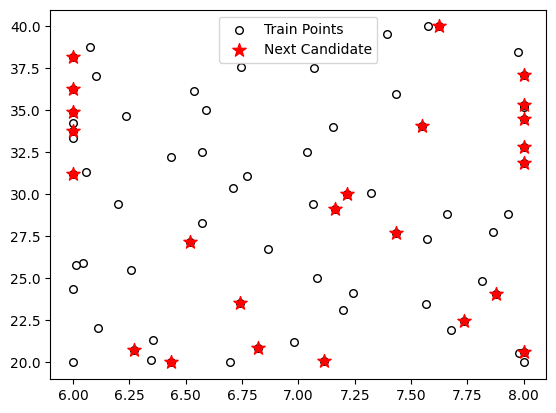

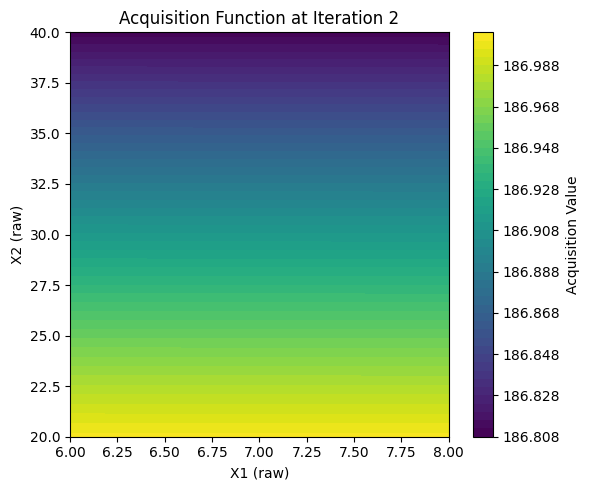

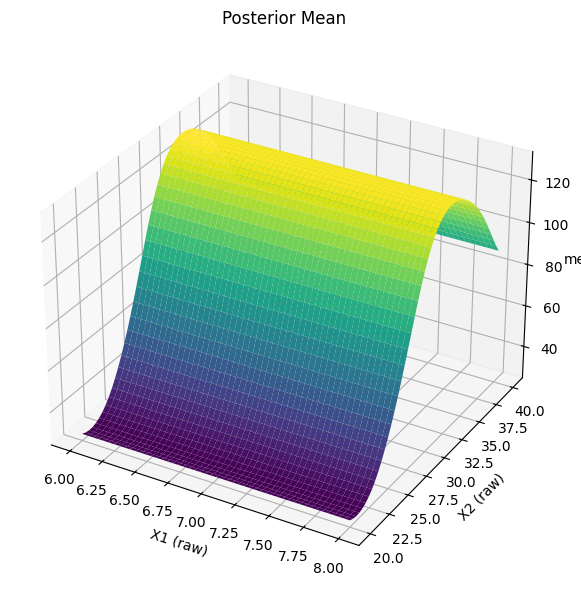

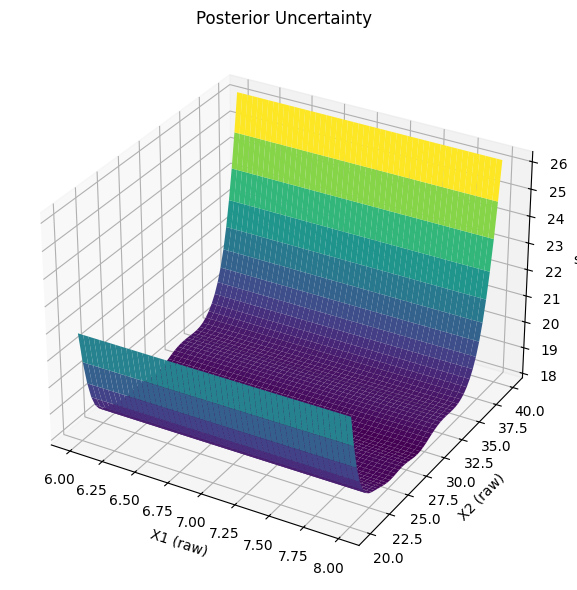

Best Y: 313.5709 at X: tensor([ 7.1637, 29.1274], dtype=torch.float64)
noise 0.710283365831052
Lengthscales: tensor([[72.1906,  0.2856]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Outputscale: tensor(0.3009, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


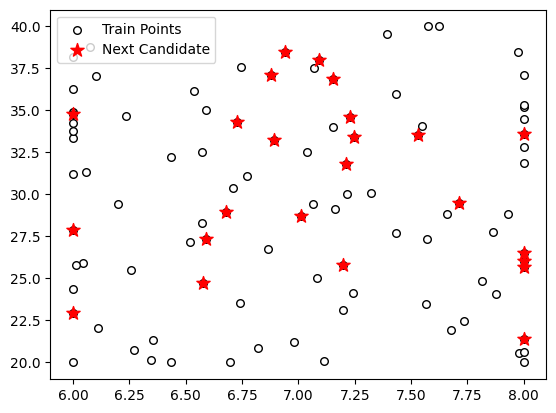

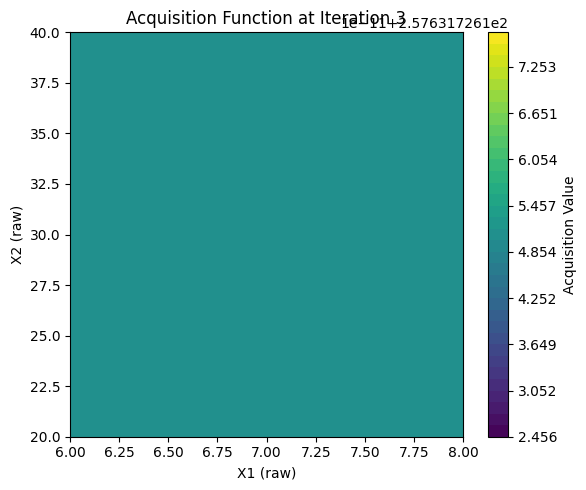

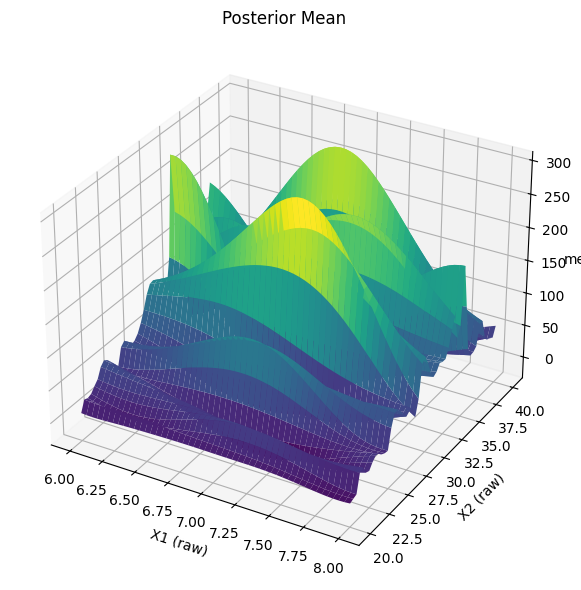

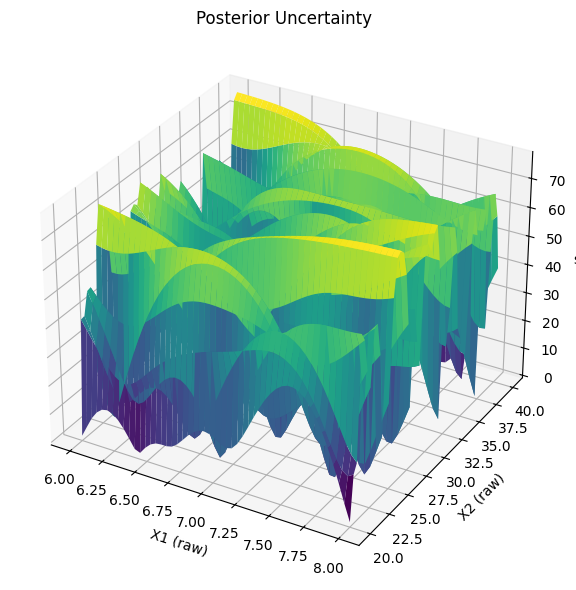

Best Y: 445.5887 at X: tensor([ 6.8930, 33.2652], dtype=torch.float64)
noise 0.00010019339489153143
Lengthscales: tensor([[0.2873, 0.0249]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Outputscale: tensor(0.8281, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


In [209]:
# UCB BO loop
n_iterations = 3
beta = 5

for i in range (n_iterations):
    # Train the model
    model, mll = train_UCB_model(train_X, train_Y)
    
    # Create the acquisition function
    acq_func = qUpperConfidenceBound(model, beta=beta)
    
    # Optimize the acquisition function
    candidate, acq_value = optimize_acqf(
        acq_func,
        bounds=bounds,
        q=24,
        num_restarts=5,
        raw_samples=20,
    )
    
    #candidate_raw = unnormalize(candidate, bounds=bounds)
    # Evaluate the objective function at the new candidate point
    new_Y = objective_function(candidate)
    
    # Append the new data to the training set
    train_X = torch.cat((train_X, candidate), dim=0)
    train_Y = torch.cat((train_Y, new_Y.unsqueeze(-1)), dim=0)

    
    # Optional: Plot acquisition function
    plt.scatter(train_X[:, 0].cpu(), train_X[:, 1].cpu(), c="white", edgecolor="black", s=30, label="Train Points")
    plt.scatter(candidate[:, 0].cpu(), candidate[:, 1].cpu(), c="red", marker="*", s=100, label="Next Candidate")
    plt.legend()
    plot_acquisition(acq_func, bounds, title=f"Acquisition Function at Iteration {i+1}")
    plot_gp_surface(model, bounds, plot_type="mean", title="Posterior Mean")
    plot_gp_surface(model, bounds, plot_type="std", title="Posterior Uncertainty")

    plt.show()
    best_idx = torch.argmax(train_Y.squeeze(-1))
    best_X = train_X[best_idx]
    best_Y = train_Y[best_idx].item()
    print(f"Best Y: {best_Y:.4f} at X: {best_X}")
    print("noise", model.likelihood.noise_covar.noise.max().item())
    print("Lengthscales:", model.covar_module.base_kernel.lengthscale)
    print("Outputscale:", model.covar_module.outputscale)